# Synchronous States in Homogeneous Populations of LIF Neurons
### NX-465 Mini-project MP2
### Spring semester 2023

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

# Simulation parameters
tau_m = 10 #ms
v0 = -50.0  #mV
eta = 0 #mV
v_rest = 15 #mV
R = 50 #membrane resistance 50 Ohm
Beta = 1e2 #ms-1

## Exercise 0: Getting Started: non-interacting population

1. Consider N = 100 non-interacting neurons, with initial voltages vi(t = 0) uniformly distributed at random between v0 and η (i.e. vi(0) ∼ U([v0, η])), and submitted to an oscillating external input Iext(t) = I0(1 + sin(ωt)), with I0 = 0.5 mA, ω = 102s−1(= 0.1 ms−1).

    - Compute the membrane potentials vi(t) and firing times of the neurons, for t ≤ Tf = 100 ms.
    
    - Plot the voltage v1(t) of the first neuron, along with the external input RIext(t).

In [2]:
N = 100 #nb neurons
I0 = 0.5 #mA
omega = 0.1 #ms-1
i_ext = lambda t: I0*(1 + np.sin(omega*t))
dt = 1e-2 #ms

In [3]:
Tf = 100 #ms simulation duration
voltage = np.zeros((N, int(Tf / dt)))
firing_times = np.zeros((N, int(Tf / dt)))

# Initialize membrane potentials randomly
voltage[:, 0] = np.random.uniform(v0, eta, size=N)
raster = []

for t in range(1, int(Tf/dt)):
    
    #dv/dt follows the LIF model, dv/dt = delta_voltage
    delta_voltage =  (1/tau_m) * (-(voltage[:, t - 1] - v_rest)+ R*i_ext((t-1)*dt))
    voltage[:, t] = voltage[:, t - 1] + dt * delta_voltage
    
    idx_reached_threshold = np.where(voltage[:, t] >= eta)[0]
    raster.append(list(idx_reached_threshold)) # list of sublists that contains idx_reached_threshold
    
    for neuron in idx_reached_threshold:
        
        if np.random.rand() < dt*Beta: 
            
            firing_times[neuron][t] = 1
            voltage[neuron, t] = v0 #reset after spike to v0 

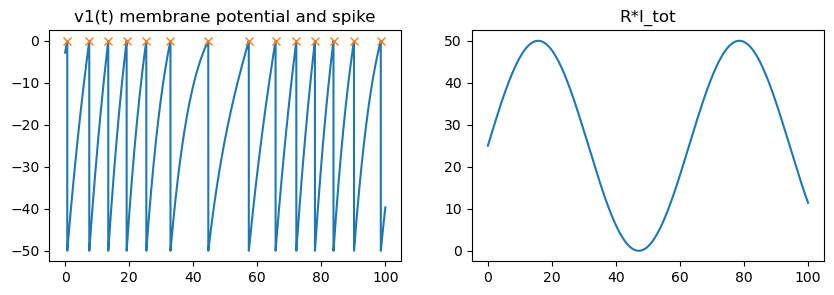

In [4]:
t_space = np.linspace(0, Tf, num = int(Tf/dt))

fig, ax = plt.subplots(1, 2, figsize = (10, 3))

ax[0].plot(t_space, voltage[0,:])
ax[0].set_title("v1(t) membrane potential and spike")
ax[0].plot(np.where(firing_times[0,:]>0, t_space, np.nan), np.where(firing_times[0,:]>0, 0, np.nan), 'x')

ax[1].plot(t_space, R*i_ext(t_space))
ax[1].set_title("R*I_tot")
plt.show()

2. Plot the low-pass filtered activity of the population, using a time bin of τA = 1ms. Make the corresponding raster plot.

How would the system behave as t → ∞? Why?

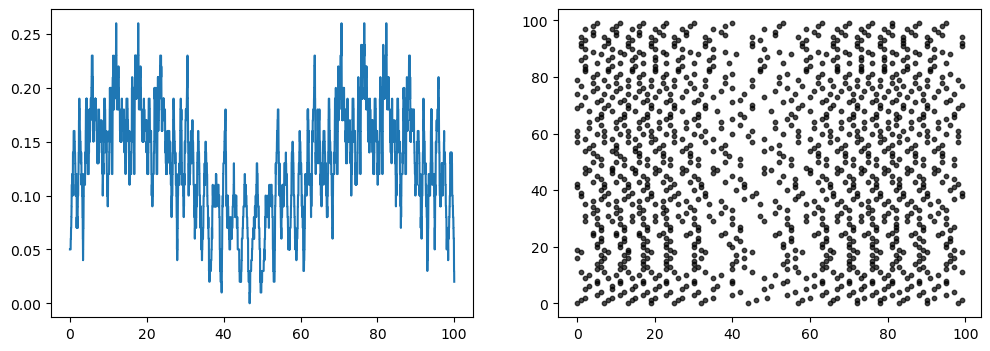

In [5]:
#for the low filtered activity
activity = [(1/dt) * sum(firing_times[:, k])/N for k in range(int(Tf/dt))] #list containing the average activity at each time step k
ta = 100 #size of the bins for convolution (Tf = 100 ms and tau_a = 1ms => ta = 100 bins) (correct ?)

filtered_activity = np.convolve(activity, np.ones(ta), mode='same')/ta

#for the raster plot
raster_ta = [] 
x_coords = []
for idx in range(100):
    neuron_idxs_firing = sum(raster[idx*ta: idx*ta + ta], []) # concatenates into one list the sublist from (idx*ta) to (idx*ta+ta)
    raster_ta.append(neuron_idxs_firing) # list of 100 sublists. 
    for n in neuron_idxs_firing:
        x_coords.append(idx)

#plot
fig, ax = plt.subplots(1,2, figsize = (12, 4))
ax[0].plot(t_space, filtered_activity, linewidth = 1.5)
ax[1].scatter(x_coords, [item for sublist in raster_ta for item in sublist], c = "k", alpha = 0.7, s = 10)
plt.show()

## Self-interacting population

In [6]:
delta = 5 #ms 
rise_time = 2 #ms
J = 20 #mV

### Ex 1. Observation of the synchronous state

1. Implement a method that integrates numerically eqs.(4) and (5), given initial conditions vi(0), and ϵA,B(0).

In [7]:
import pandas as pd

def calculate_potential(T_f, vt0, eA0, eB0, current, Beta, save = False):
    voltage = np.zeros((N, int(T_f / dt)))
    firing_neurons = [[]]
    kernel = pd.DataFrame({"A": np.zeros(int(T_f/dt)), "B": np.zeros(int(T_f/dt))})

    voltage[:, 0] = vt0
    kernel.loc[0, "A"] = eA0
    kernel.loc[0, "B"] = eB0

    for t in range(1, int(T_f/dt)): 
        
        kernel.loc[t, "B"] = kernel.loc[t-1, "B"] + (1/rise_time) * ((len(firing_neurons[t-1])/N)- dt*kernel.loc[t-1, "B"])
        
        kernel.loc[t, "A"] = kernel.loc[t-1, "A"] + (dt/rise_time) *(kernel.loc[t-1, "B"] - kernel.loc[t-1, "A"])
        
        delta_voltage = (1/tau_m) * (-(voltage[:, t - 1] - v_rest)+ R*current(t-1) + tau_m*J*kernel.iloc[t-1-int(delta/dt), 0])
        voltage[:, t] = voltage[:, t - 1] + dt * delta_voltage

        fn_t = list(np.where(voltage[:, t] > eta)[0])
        noiseless_neurons = []
        for neuron in fn_t:
            if np.random.rand() < dt*Beta: 
                
                noiseless_neurons.append(neuron)
                voltage[neuron, t] = v0 
                
        firing_neurons.append(noiseless_neurons)
    
    
    if save:
        synchronous = (voltage[:, -1], kernel.iloc[-1, 0], kernel.iloc[-1, 1])
        return voltage, firing_neurons, synchronous
    else:
        return voltage, firing_neurons

In [8]:
Tf2 = 600

In [52]:
v_, firing_neurons, synchronous = calculate_potential(Tf2, np.random.uniform(v0, eta, size=N),
                                         0, 0, lambda t: 0, Beta, save = True)

### 2. Spontaneous dynamics of the system

1. Make a plot of the activity (low-passed with τA = 0.5ms) and a raster plot, for the first 200ms and last 30ms of the evolution.

In [10]:
def plot_raster(fn, ta, T_f):
    
    
    t_space2= np.linspace(0, T_f, num = int(T_f/dt))
    
    activity = [(1/dt) * (len(fn[k])/N) for k in range(int(T_f/dt))]
    filtered_activity = np.convolve(activity, np.ones(ta), mode='same')/ta
    
    raster_neurons = []
    x_coords = []
    for idx in range(T_f):
        neuron_idxs_firing = sum(fn[idx*int((1/dt)): idx*int((1/dt)) + int((1/dt))], [])
        raster_neurons.append(neuron_idxs_firing)
    
        for n in neuron_idxs_firing:
            x_coords.append(idx)
        

    time_frames = [(0, 200), (569, 599)]
    fig, ax = plt.subplots(2,2, figsize = (12, 6))

    xcoords_np = np.array(x_coords)
    raster_neurons_np = np.array([item for sublist in raster_neurons for item in sublist])
    for idx, timef in enumerate(time_frames):
    
        ax[idx, 0].plot(t_space2[int(timef[0]/dt):int(timef[1]/dt)], filtered_activity[
            int(timef[0]/dt):int(timef[1]/dt)])
    
        ax[idx, 1].scatter(xcoords_np[(xcoords_np > timef[0]) & (xcoords_np < timef[1])], raster_neurons_np[
            (xcoords_np > timef[0]) & (xcoords_np < timef[1])], c = "k", alpha = 0.7, s = 5)
    plt.show()
                           
    return x_coords

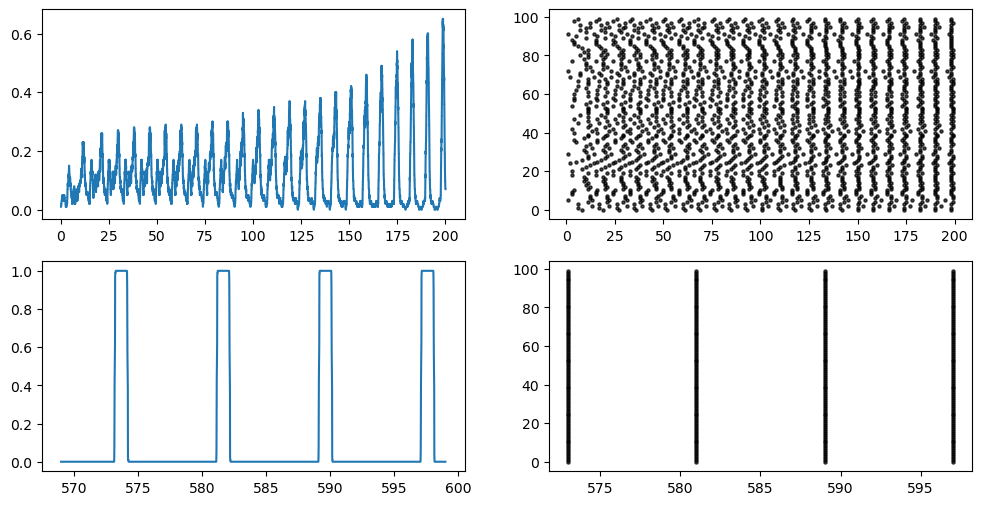

In [11]:
x_coords = plot_raster(firing_neurons, ta=100, T_f=Tf2)

Why is the activity composed of sharp oscillations/peaks? because of synchronisation

2. Compute the period T between two peaks.

To compute the time between 2 peaks, we can use the x_coordinates of the raster plot towards the end of the simulation and determine the T period.

In [26]:
x_coords_ar = np.array(x_coords)
fireT = np.unique(x_coords_ar[x_coords_ar >= 585])
periods = []
for idx in range(len(fireT) - 1):
    periods.append(fireT[idx+1] - fireT[idx])

print("T =", round(np.mean(periods), 4))

T = 8.0


3. How would the network behave as t → ∞?

It would keep firing very sharp spikes with all N=100 neurons synchronised at a time period T = 8ms

#### 3. Now consider a constant external input current Iext(t) = I0 = −0.25mA.

In [15]:
v_, firing_neurons2 = calculate_potential(Tf2, np.random.uniform(v0, eta, size=N), 0, 0,
                                          lambda t: -0.25, Beta)

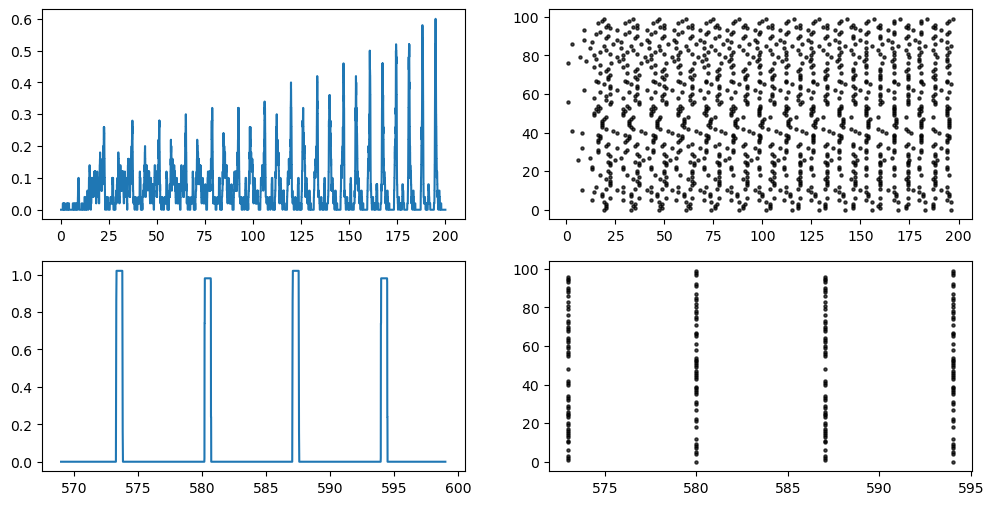

In [16]:
x_coords = plot_raster(firing_neurons2, ta=50, T_f=Tf2)

## Ex 2. Transition between states

In [17]:
#firing_neurons2[35000:]

In [18]:
def relative_ftimes(firing_n):
    reference_n = 0
    reference_neuron_time = 0
    
    inter_spike_ref = []
    relative_firing = [[] for i in range(100)]
    
    for t, fn_t in enumerate(firing_n): 
        if fn_t:
            for neuron in fn_t:
                if (neuron != reference_n):
                    relative_firing[neuron].append(dt*(t - reference_neuron_time))
            if (reference_n in fn_t): 
                inter_spike_ref.append(dt*(t - reference_neuron_time))
                reference_neuron_time = t
    
    return relative_firing, inter_spike_ref

In [ ]:
def rel_times2(firing_n): 
    
    reference_n = 0
    reference_intervals = []
    
    for t, fn_t in enumerate(firing_n):
        if reference_n in fn_t:
            reference_intervals.append(t*dt)
    
    
    relative_firing  = [np.zeros(len(reference_intervals)) for i in range(100)]
    
    for ri in reference_intervals:
        
    

In [19]:
import seaborn as sns
palette = sns.color_palette("Set2", N)

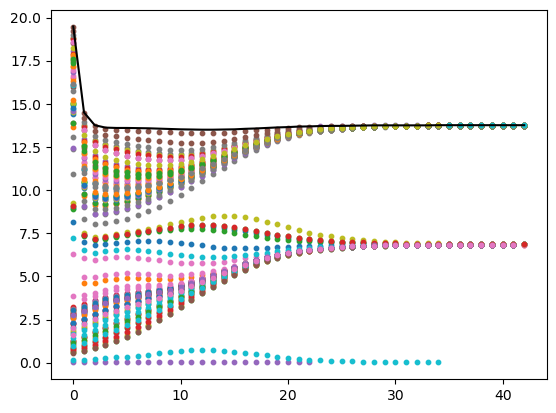

In [138]:
relative_firing_times, inter_spike_reference = relative_ftimes(firing_neurons2)

def plot_rft(rft, isr):
    for idx, rft_n in enumerate(rft):
        plt.scatter(range(len(rft_n)), rft_n, s = 10)
    plt.plot(range(len(isr)), isr, c = 'k')
    plt.show()
    
plot_rft(relative_firing_times, inter_spike_reference)

2. Consider the step external input Iext(t) = I0 · 1{t>Tstep}, with I0 = −0.25mA, Tstep = 500ms. Using the same initial conditions as in Qus.2&3, run the time evolution for t ≤ Tf = 1000ms.

In [142]:
def i_ext_step(t):
    Tstep = 500
    I0 = -0.25
    if (t*dt > Tstep):
        return I0
    return 0

Tf3 = 1000
v_, firing_neurons3 = calculate_potential(Tf3, np.random.uniform(v0, eta, size=N), 0, 0, i_ext_step, Beta)

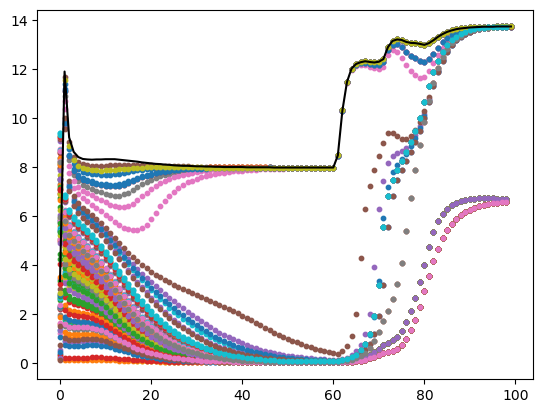

In [143]:
rft2, isr2 = relative_ftimes(firing_neurons3)
plot_rft(rft2, isr2)

3. In this question, set the noise parameter to β = 25ms−1. Compute the critical value Ic of the external input at which the switch happens. To do this, set initially the system in the synchronous state, and run the time evolution for t ≤ Tf = 2000ms, with the external input Iext(t) = I0 · t/Tf .

In [82]:
#synchronous

In [116]:
Tf4 = 2000
def i_ext_critique(t):
    I02 = -0.25
    return I02*t*dt/Tf4

Beta_prime = 25 #neuron fires 25% of the time
v_, firing_neurons4 = calculate_potential(Tf4, synchronous[0], synchronous[1], synchronous[2], i_ext_critique,
                                          Beta_prime)

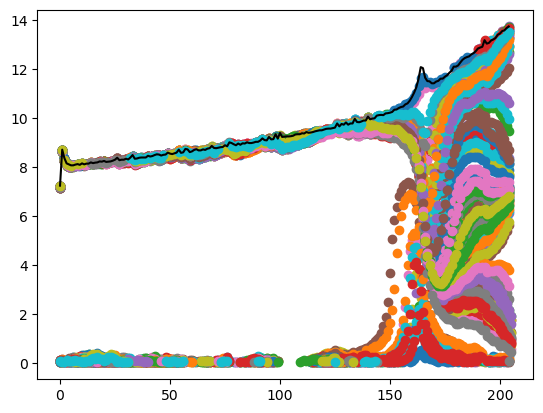

In [131]:
rft3, isr3 = relative_ftimes(firing_neurons4)
plot_rft(rft3, isr3)

We are going to estimate that this happens at the 125th spike

In [132]:
i_ext_critique(sum(isr3[:125])/dt)
#We find 0.14mA for critical current I

-0.13640125

### Ex 3. Stability of the synchronous state

#### Dilation factor

In [51]:
import random

In [58]:
perturbation = synchronous[0].copy()
perturbation[0] += 2

In [100]:
v_, firing_neurons5 = calculate_potential(100, perturbation, synchronous[1], synchronous[2], 
                                          lambda t: 0, Beta)
def firing_delays(firing_n):
    clusterT = []
    cluster_n = 1
    reference_n = 0
    firings = []
    firing_delays = []
    
    for t, fn_t in enumerate(firing_n):
        
        if fn_t:
            if cluster_n in fn_t: 
                clusterT.append(dt*t)
            if reference_n in fn_t: 
                firings.append(dt*t)
                
    for fidx, f in enumerate(firings):
        firing_delays.append(np.abs(f - clusterT[fidx]))
        
    return firing_delays

In [101]:
import statsmodels.api as sm
import statsmodels.formula.api as smf

delay_df = pd.DataFrame(firing_delays(firing_neurons5), columns = ["firing_delays"]).apply(np.log)
delay_df["spike_n"] = delay_df.index
display(delay_df)

mod = smf.ols(formula='firing_delays ~ spike_n', data=delay_df)
res = mod.fit()
print(res.summary())

,firing_delays,spike_n
0,-1.469676,0
1,-1.714798,1
2,-1.897120,2
3,-2.040221,3
4,-2.120264,4
5,-2.302585,5
6,-2.407946,6
7,-2.525729,7
8,-2.659260,8
9,-2.813411,9


                            OLS Regression Results                            
Dep. Variable:          firing_delays   R-squared:                       0.992
Model:                            OLS   Adj. R-squared:                  0.991
Method:                 Least Squares   F-statistic:                     1189.
Date:                Fri, 26 May 2023   Prob (F-statistic):           9.97e-12
Time:                        17:31:15   Log-Likelihood:                 19.909
No. Observations:                  12   AIC:                            -35.82
Df Residuals:                      10   BIC:                            -34.85
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -1.5471      0.027    -56.478      0.0

/Users/louis/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/_stats_py.py:1769: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=12
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


In [102]:
#The coefficient we found is -0.14 and corresponds to the log(c)
print(res.params["spike_n"])
print(np.exp(res.params["spike_n"]))

-0.1454566084517312
0.8646274067818495


In [87]:
#c = 0.86

## Region of attraction

In [132]:
def region_attraction(T_f, vt0, eA0, eB0, Beta):
    
    interacting_voltage = np.zeros((N, int(T_f / dt)))
    non_interacting_voltage = np.zeros((N, int(T_f / dt)))
    
    firing_neuronsI = [[]]
    firing_neuronsNI = [[]]
    kernel = pd.DataFrame({"A": np.zeros(int(T_f/dt)), "B": np.zeros(int(T_f/dt))})

    interacting_voltage[:, 0] = vt0
    kernel.loc[0, "A"] = eA0
    kernel.loc[0, "B"] = eB0
    non_interacting_voltage[:, 0] = np.random.uniform(v0, eta, size=N)
    
    for t in range(1, int(T_f/dt)): 
        
        kernel.loc[t, "B"] = kernel.loc[t-1, "B"] + (1/rise_time) * ((len(firing_neuronsI[t-1])/N)- dt*kernel.loc[t-1, "B"])
        
        kernel.loc[t, "A"] = kernel.loc[t-1, "A"] + (dt/rise_time) *(kernel.loc[t-1, "B"] - kernel.loc[t-1, "A"])
        
        
        delta_voltage = (1/tau_m) * (-(interacting_voltage[:, t - 1] - v_rest) + tau_m*J*kernel.iloc[t-1-int(delta/dt), 0])
        interacting_voltage[:, t] = interacting_voltage[:, t - 1] + dt * delta_voltage
        
        i_synchr = tau_m*J*kernel.iloc[t-1-int(delta/dt), 0]/R
        
        delta_voltage_non =  (1/tau_m) * (-(non_interacting_voltage[:, t - 1] - v_rest)+ R*i_synchr)
        non_interacting_voltage[:, t] = non_interacting_voltage[:, t - 1] + dt * delta_voltage_non
        
        #interacting
        fn_t_i = list(np.where(interacting_voltage[:, t] > eta)[0])
        noiseless_neurons_i = []
        for neuron in fn_t_i:
            if np.random.rand() < dt*Beta: 
                
                noiseless_neurons_i.append(neuron)
                interacting_voltage[neuron, t] = v0 
                
        firing_neuronsI.append(noiseless_neurons_i)
        
        #non interacting
        fn_t_ni = list(np.where(non_interacting_voltage[:, t] > eta)[0])
        noiseless_neurons_ni = []
        for neuron in fn_t_ni:
            if np.random.rand() < dt*Beta: 
                noiseless_neurons_ni.append(neuron)
                non_interacting_voltage[neuron, t] = v0 
                
        firing_neuronsNI.append(noiseless_neurons_ni)

    return firing_neuronsI, firing_neuronsNI

In [133]:
stable_sync_state = np.full(100, -27)

In [134]:
Tf5 = 500
firingI, firingNI = region_attraction(Tf5, stable_sync_state, synchronous[1], synchronous[2], Beta)